# Extract historic data from Guandu

Sometimes Guandu data is included in reports of more broad geographical areas like the city of Rio de Janeiro. So we'll treat them specially. As written in the report of Rio de Janeiro of 2005:

_"A partir de Maio de 2005 para melhor verificação da qualidade da água fornecida ao município as análises de qualidade de água passaram a ter controles estatísticos por sistema de
abastecimento."_

I would translate it to English as:

_"After May 2005, in order to better verify the quality of the water provided to the municipality, the water quality analysis have now statistical control per supply system."_

Because of that, we can't then use data from reports of 2004, because they are collected per municipality, not by water supply system.

First, let's get the path for every guandu report.

In [146]:
import os
import glob
import tabula
import datetime
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [147]:
reports = {
    2005: {
        'area': (56.529625151148736, 36.69803250641574, 67.04957678355503, 63.98631308810949),
        'columns': ('month', 'colour', 'turbity', 'pH', 'free_chlorine', 'total_coliforms_icnt', 'thermo_coliforms_icnt'),
        'page': 2,
        'shiftlast': True,
        'percentages': (('total_coliforms_pct', 'total_coliforms_icnt', 8557/8),),
        'invertpct': {'total_coliforms_pct'},
    },
    # 2006 is missing
    2007: {
        'area': (69.69783352337514, 34.95967741935484, 81.92702394526796, 64.83870967741936),
        'page': 1,
        'columns': ('month', 'colour', 'turbity', 'pH', 'free_chlorine', 'total_coliforms_icnt', 'thermo_coliforms_icnt'),
        'shiftlast': True,
        'percentages': (('total_coliforms_pct', 'total_coliforms_icnt', 8868/12),),
        'invertpct': {'total_coliforms_pct'},
    },
    2008: {
        'area': (72.71765017200318, 36.04475355306925, 86.74252447737497, 63.804052010886004),
        'page': 1,
        'columns': ('month', 'colour', 'turbity', 'pH', 'free_chlorine', 'total_coliforms_icnt', 'thermo_coliforms_icnt'),
        'percentages': (('total_coliforms_pct', 'total_coliforms_icnt', 9097/12),),
        'invertpct': {'total_coliforms_pct'},
    },
    2009: {
        'area': (8.135593220338983, 1.6617790811339197, 56.440677966101696, 31.867057673509287),
        'page': 2,
        'shiftlast': True,
        'columns': ('month', 'colour_turbity_tests', 'chlorine_bacteriology_tests', 'turbity_cnt', 'colour_cnt',
                    'free_chlorine_cnt', 'total_coliforms_cnt', 'thermo_coliforms_cnt'),
        'percentages': (('turbity_pct', 'turbity_cnt', 'colour_turbity_tests'),
                       ('colour_pct', 'colour_cnt', 'colour_turbity_tests'),
                       ('free_chlorine_pct', 'free_chlorine_cnt', 'chlorine_bacteriology_tests'),
                       ('total_coliforms_pct', 'total_coliforms_cnt', 'chlorine_bacteriology_tests'),
                       ('thermo_coliforms_pct', 'thermo_coliforms_cnt', 'chlorine_bacteriology_tests')),
    },
    2010: {
        'area': (8.135593220338983, 1.6617790811339197, 56.440677966101696, 31.867057673509287),
        'page': 2,
        'shiftlast': True,
        'columns': ('month', 'colour_turbity_tests', 'chlorine_bacteriology_tests', 'turbity_cnt', 'colour_cnt',
                    'free_chlorine_cnt', 'total_coliforms_cnt', 'thermo_coliforms_cnt'),
        'percentages': (('turbity_pct', 'turbity_cnt', 'colour_turbity_tests'),
                       ('colour_pct', 'colour_cnt', 'colour_turbity_tests'),
                       ('free_chlorine_pct', 'free_chlorine_cnt', 'chlorine_bacteriology_tests'),
                       ('total_coliforms_pct', 'total_coliforms_cnt', 'chlorine_bacteriology_tests'),
                       ('thermo_coliforms_pct', 'thermo_coliforms_cnt', 'chlorine_bacteriology_tests')),
    },
    2011: {
        'area': (7.525655644241732, 2.4188671638782506, 34.83466362599772, 32.37250554323725),
        'page': 2,
        'columns': ('month', 'chlorine_bacteriology_turbity_tests', 'colour_tests', 'turbity_cnt', 'colour_cnt',
                    'free_chlorine_cnt', 'total_coliforms_cnt', 'thermo_coliforms_cnt'),
        'percentages': (('turbity_pct', 'turbity_cnt', 'chlorine_bacteriology_turbity_tests'),
                       ('colour_pct', 'colour_cnt', 'colour_tests'),
                       ('free_chlorine_pct', 'free_chlorine_cnt', 'chlorine_bacteriology_turbity_tests'),
                       ('total_coliforms_pct', 'total_coliforms_cnt', 'chlorine_bacteriology_turbity_tests'),
                       ('thermo_coliforms_pct', 'thermo_coliforms_cnt', 'chlorine_bacteriology_turbity_tests')),
    },
    2012: {
        'area': (7.525655644241732, 2.297923805684338, 34.7206385404789, 32.412819995968555),
        'page': 2,
        'columns': ('month', 'chlorine_bacteriology_turbity_tests', 'colour_tests', 'turbity_cnt', 'colour_cnt',
                    'free_chlorine_cnt', 'total_coliforms_cnt', 'e_coli_cnt'),
        'percentages': (('turbity_pct', 'turbity_cnt', 'chlorine_bacteriology_turbity_tests'),
                       ('colour_pct', 'colour_cnt', 'colour_tests'),
                       ('free_chlorine_pct', 'free_chlorine_cnt', 'chlorine_bacteriology_turbity_tests'),
                       ('total_coliforms_pct', 'total_coliforms_cnt', 'chlorine_bacteriology_turbity_tests'),
                       ('e_coli_pct', 'e_coli_cnt', 'chlorine_bacteriology_turbity_tests')),
    },
    2013: {
        'area': (7.525655644241732, 2.297923805684338, 34.7206385404789, 32.412819995968555),
        'page': 2,
        'columns': ('month', 'chlorine_bacteriology_turbity_tests', 'colour_tests', 'turbity_cnt', 'colour_cnt',
                    'free_chlorine_cnt', 'total_coliforms_cnt', 'e_coli_cnt'),
        'percentages': (('turbity_pct', 'turbity_cnt', 'chlorine_bacteriology_turbity_tests'),
                       ('colour_pct', 'colour_cnt', 'colour_tests'),
                       ('free_chlorine_pct', 'free_chlorine_cnt', 'chlorine_bacteriology_turbity_tests'),
                       ('total_coliforms_pct', 'total_coliforms_cnt', 'chlorine_bacteriology_turbity_tests'),
                       ('e_coli_pct', 'e_coli_cnt', 'chlorine_bacteriology_turbity_tests')),
    },
    2014: {
        'area': (7.525655644241732, 2.3382382584156423, 34.94868871151653, 32.493448901431165),
        'page': 2,
        'columns': ('month', 'chlorine_bacteriology_turbity_tests', 'colour_tests', 'turbity_cnt', 'colour_cnt',
                    'free_chlorine_cnt', 'total_coliforms_cnt', 'e_coli_cnt'),
        'percentages': (('turbity_pct', 'turbity_cnt', 'chlorine_bacteriology_turbity_tests'),
                       ('colour_pct', 'colour_cnt', 'colour_tests'),
                       ('free_chlorine_pct', 'free_chlorine_cnt', 'chlorine_bacteriology_turbity_tests'),
                       ('total_coliforms_pct', 'total_coliforms_cnt', 'chlorine_bacteriology_turbity_tests'),
                       ('e_coli_pct', 'e_coli_cnt', 'chlorine_bacteriology_turbity_tests')),
    },
    2015: {
        'area': (4.362703165098375, 2.35934664246824, 40.547476475620186, 31.45795523290986),
        'page': 2,
        'columns': ('month', 'chlorine_bacteriology_turbity_tests', 'colour_tests', 'turbity', 'colour',
                    'free_chlorine', 'total_coliforms_pct', 'total_coliforms_rec_pct', 'e_coli_pct',
                    'e_coli_rec_pct'),
    },
    # 2016 report has an image, not a table
    2016: {
        'columns': ('month', 'chlorine_bacteriology_turbity_tests', 'colour_tests', 'turbity', 'colour',
                    'free_chlorine', 'total_coliforms_pct', 'total_coliforms_rec_pct', 'e_coli_pct',
                    'e_coli_rec_pct'),
        'predf': pd.DataFrame(data={
            'c1': ['JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN', 'JUL', 'AGO', 'SET', 'OUT', 'NOV', 'DEZ'],
            'c2': [976, 974, 1023, 1050, 1026, 1033, 1040, 1055, 1091, 976, 1050, 988],
            'c3': [532, 529, 560, 561, 550, 544, 557, 578, 581, 525, 572, 545],
            'c4': [1.6, 2.3, 2.3, 2.4, 2.8, 1.7, 2.2, 2.2, 2.1, 1.9, 2.5, 2.4],
            'c5': [6.0, 7.0, 6.0, 6.0, 8.0, 7.0, 6.0, 7.0, 6.0, 5.0, 6.0, 6.0],
            'c6': [1.7, 1.6, 1.8, 1.8, 1.7, 1.8, 1.8, 1.7, 1.6, 1.7, 1.6, 1.7],
            'c7': [98.1, 97.7, 94.8, 94.1, 93.7, 94.0, 94.9, 94.6, 96.2, 91.6, 92.4, 93.7],
            'c8': [99.9, 99.9, 99.5, 99.7, 99.3, 99.9, 99.5, 99.7, 99.8, 99.0, 99.5, 99.5],
            'c9': [99.9, 99.8, 99.7, 99.8, 99.3, 99.5, 99.7, 99.5, 99.5, 99.5, 99.1, 99.8],
            'c10': [100.0, 100.0, 100.0, 100.0, 99.9, 100.0, 100.0, 100.0, 99.9, 100.0, 100.0, 100.0],
        }),
    },
    2017: {
        'area': (8.022284122562674, 1.5513897866839044, 54.038997214484674, 33.80736910148675),
        'page': 2,
        'columns': ('month', 'chlorine_bacteriology_turbity_tests', 'colour_tests', 'turbity', 'colour',
                    'free_chlorine', 'total_coliforms_pct', 'total_coliforms_rec_pct', 'e_coli_pct',
                    'e_coli_rec_pct'),
    },
    2018: {
        'area': (8.0, 1.3680781758957654, 54.0, 33.811074918566774),
        'page': 2,
        'columns': ('month', 'chlorine_bacteriology_turbity_tests', 'colour_tests', 'turbity', 'colour',
                    'free_chlorine', 'total_coliforms_pct', 'total_coliforms_rec_pct', 'e_coli_pct',
                    'e_coli_rec_pct'),
    },
    # 2019 report has an image, not a table
    2019: {
        'columns': ('month', 'chlorine_bacteriology_turbity_tests', 'colour_tests', 'turbity', 'colour',
                    'free_chlorine', 'total_coliforms_pct', 'total_coliforms_rec_pct', 'e_coli_pct',
                    'e_coli_rec_pct'),
        'predf': pd.DataFrame(data={
            'c1': ['JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN', 'JUL', 'AGO', 'SET', 'OUT', 'NOV', 'DEZ'],
            'c2': [1016, 1027, 959, 973, 1024, 1018, 1040, 990, 1008, 1011, 1018, 967],
            'c3': [566, 741, 539, 542, 558, 560, 596, 561, 572, 552, 405, 535],
            'c4': [3.6, 2.9, 3.6, 4.0, 3.8, 2.8, 2.6, 1.7, 2.0, 1.8, 2.2, 2.5],
            'c5': [8.0, 9.0, 9.0, 9.0, 9.0, 8.0, 8.0, 5.0, 5.0, 5.0, 7.0, 9.0],
            'c6': [1.8, 1.9, 1.7, 1.6, 1.7, 1.8, 1.7, 1.7, 1.8, 1.8, 1.7, 1.7],
            'c7': [97.8, 94.4, 95.2, 95.9, 93.6, 94.7, 95.3, 94.7, 96.3, 96.7, 86.0, 88.6],
            'c8': [99.8, 99.8, 99.0, 99.8, 99.3, 99.3, 99.0, 99.0, 99.7, 99.2, 99.1, 99.4],
            'c9': [99.8, 99.7, 99.0, 99.4, 99.8, 99.8, 99.7, 99.6, 99.8, 99.7, 99.7, 99.5],
            'c10': [100.0, 99.9, 99.8, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0],
        }),
    },
    2020: {
        'area': (25.725806451612904, 4.104903078677309, 49.71774193548387, 32.782212086659065),
        'page': 2,
        'columns': ('month', 'chlorine_bacteriology_turbity_tests', 'colour_tests', 'turbity', 'colour',
                    'free_chlorine', 'total_coliforms_pct', 'total_coliforms_rec_pct', 'e_coli_pct',
                    'e_coli_rec_pct'),
        'shiftlast': True,
    }
}

In [148]:
for year in os.listdir('input'):
    try:
        year_int = int(year)
    except ValueError:
        continue
    if year_int not in reports:
        continue
    # Newer reports have Guandu data exclusively
    path = os.path.join('input', year, 'guandu.pdf')
    if os.path.isfile(path):
        reports[year_int]['path'] = path
        continue
    # Older reports include Guandu in Rio de Janeiro reports
    altpath = os.path.join('input', year, 'rio_de_janeiro.pdf')
    if os.path.isfile(altpath):
        reports[year_int]['path'] = altpath

Let's take a look at the years we're able to obtain.

In [149]:
print(*sorted(reports.keys()), sep=', ')

2005, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020


Let's now extract the tables from these PDFs. We need to define the area and page in the PDF where the table resides. This part is very manual, because the layout of reports have really changed over time, so we can't fully rely on `tabula-py` auto-detect feature...

Also, a common issue with tables parsed by `tabula-py` is that the last collumn is shifted by one to the side.

We also name columns with keywords for common access interface amongs reports.

In [150]:
for year, reportdata in reports.items():
    path = reportdata.get('path')
    area = reportdata.get('area')
    page = reportdata.get('page')
    cols = reportdata.get('columns')
    predf = reportdata.get('predf')
    pcts = reportdata.get('percentages')
    ipct = reportdata.get('invertpct')
    if path and area and page and cols:
        dfs = tabula.read_pdf(path, pages=page, area=area,
                              relative_area=True, silent=True, lattice=True)
        assert dfs, year
        df = dfs[0]
    elif predf is not None:
        df = predf
    else:
        print(year)
        continue
    df = df.dropna(how='all', axis=0)
    df = df.dropna(how='all', axis=1)
    if reportdata.get('shiftlast', False):
        df.iloc[-1] = df.tail(1).shift(1, axis=1).iloc[0]
    df = df.tail(12)
    df = df.dropna(how='all', axis=1)
    df.columns = cols
    start = datetime.datetime(year, 1, 1)
    df.index = pd.date_range(start=start, periods=12, freq='M')
    df = df.drop(columns=['month'])
    df = df.dropna(how='all', axis=0)
    df = df.astype(str)
    df = df.apply(lambda x: x.str.strip())
    df = df.apply(lambda x: x.str.replace(',', '.'))
    df = df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    if pcts:
        for pct_name, cnt_name, total in pcts:
            if total in df.columns:
                pct = 100 * df[cnt_name] / df[total]
            else:
                pct = 100 * df[cnt_name] / total
            if ipct and pct_name in ipct:
                pct = 100 - pct
            df[pct_name] = pct
    reportdata['df'] = df

Let's now export this data to CSV format.

In [151]:
basedir = os.path.join('output', 'guandu')
for year, reportdata in reports.items():
    df = reportdata['df']
    outpath = os.path.join(basedir, 'yearly_' + str(year) + '.csv')
    reportdata['outpath'] = outpath
    df.to_csv(outpath)

In [152]:
dfs = [data['df'] for data in reports.values()]
df = pd.concat(dfs, axis=0)

In [153]:
df.shape

(176, 24)

In [154]:
df.count()

colour                                 104
turbity                                104
pH                                      32
free_chlorine                          104
total_coliforms_icnt                    32
thermo_coliforms_icnt                   32
total_coliforms_pct                    176
colour_turbity_tests                    24
chlorine_bacteriology_tests             24
turbity_cnt                             72
colour_cnt                              72
free_chlorine_cnt                       72
total_coliforms_cnt                     72
thermo_coliforms_cnt                    36
turbity_pct                             72
colour_pct                              72
free_chlorine_pct                       72
thermo_coliforms_pct                    36
chlorine_bacteriology_turbity_tests    120
colour_tests                           120
e_coli_cnt                              36
e_coli_pct                             108
total_coliforms_rec_pct                 72
e_coli_rec_

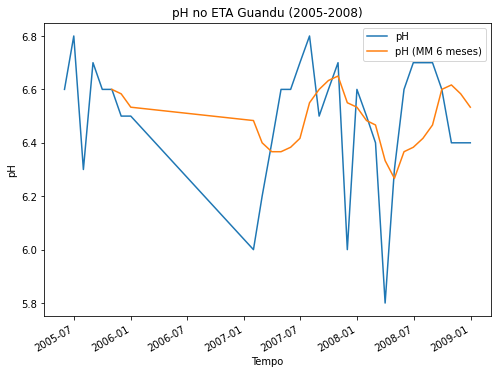

In [171]:
plt.figure(figsize=[8,6])
plt.title('pH no ETA Guandu (2005-2008)')
df.pH.plot(label='pH')
df.pH.rolling(window=6).mean().plot(label='pH (MM 6 meses)')
plt.xlabel('Tempo')
plt.ylabel('pH')
plt.legend()
plt.show()

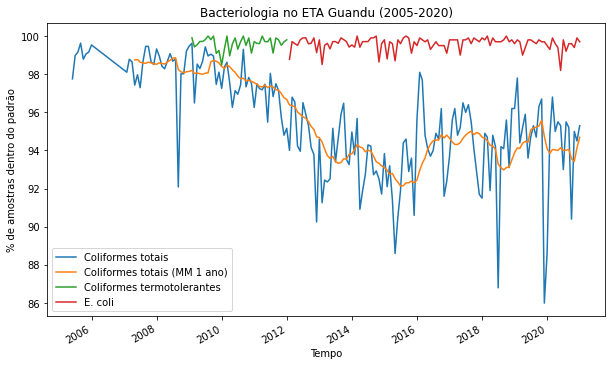

In [161]:
plt.figure(figsize=[10,6])
plt.title('Bacteriologia no ETA Guandu (2005-2020)')
df.total_coliforms_pct.plot(label='Coliformes totais')
df.total_coliforms_pct.rolling(window=12).mean().plot(label='Coliformes totais (MM 1 ano)')
df.thermo_coliforms_pct.plot(label='Coliformes termotolerantes')
df.e_coli_pct.plot(label='E. coli')
plt.xlabel('Tempo')
plt.ylabel('% de amostras dentro do padrão')
plt.legend(loc='best')
plt.show()

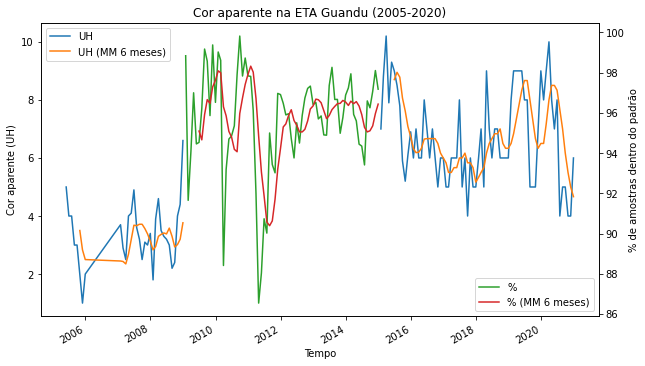

In [156]:
plt.figure(figsize=[10,6])
plt.title('Cor aparente na ETA Guandu (2005-2020)')
ax1 = df.colour.plot(label='UH')
df.colour.rolling(window=6).mean().plot(label='UH (MM 6 meses)')
ax1.set_ylabel('Cor aparente (UH)')
plt.legend(loc='best')
plt.xlabel('Tempo')
ax2 = df.colour_pct.plot(label='%', secondary_y=True)
df.colour_pct.rolling(window=6).mean().plot(label='% (MM 6 meses)', secondary_y=True)
ax2.set_ylabel('% de amostras dentro do padrão')
plt.legend(loc='lower right')
plt.show()

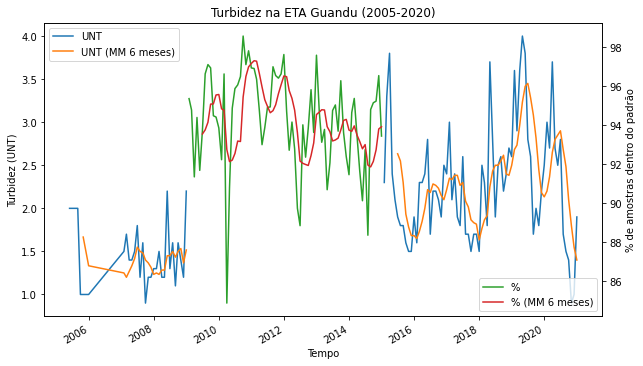

In [157]:
plt.figure(figsize=[10,6])
plt.title('Turbidez na ETA Guandu (2005-2020)')
ax1 = df.turbity.plot(label='UNT')
df.turbity.rolling(window=6).mean().plot(label='UNT (MM 6 meses)')
ax1.set_ylabel('Turbidez (UNT)')
plt.legend(loc='best')
plt.xlabel('Tempo')
ax2 = df.turbity_pct.plot(label='%', secondary_y=True)
df.turbity_pct.rolling(window=6).mean().plot(label='% (MM 6 meses)', secondary_y=True)
ax2.set_ylabel('% de amostras dentro do padrão')
plt.legend(loc='lower right')
plt.show()

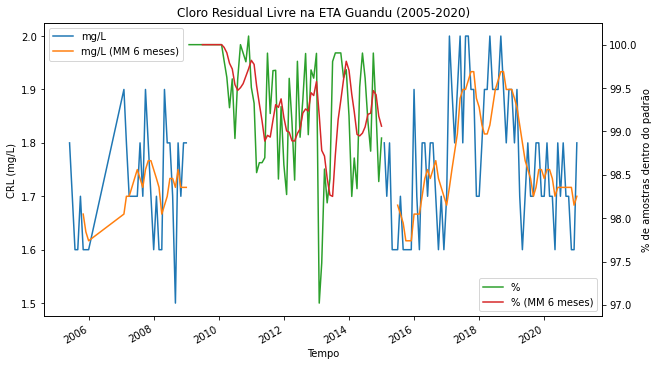

In [158]:
plt.figure(figsize=[10,6])
plt.title('Cloro Residual Livre na ETA Guandu (2005-2020)')
ax1 = df.free_chlorine.plot(label='mg/L')
df.free_chlorine.rolling(window=6).mean().plot(label='mg/L (MM 6 meses)')
ax1.set_ylabel('CRL (mg/L)')
plt.legend(loc='best')
plt.xlabel('Tempo')
ax2 = df.free_chlorine_pct.plot(label='%', secondary_y=True)
df.free_chlorine_pct.rolling(window=6).mean().plot(label='% (MM 6 meses)', secondary_y=True)
ax2.set_ylabel('% de amostras dentro do padrão')
plt.legend(loc='lower right')
plt.show()

colour                  104
turbity                 104
pH                       32
free_chlorine           104
total_coliforms_pct     176
turbity_pct              72
colour_pct               72
free_chlorine_pct        72
thermo_coliforms_pct     36
e_coli_pct              108
dtype: int64


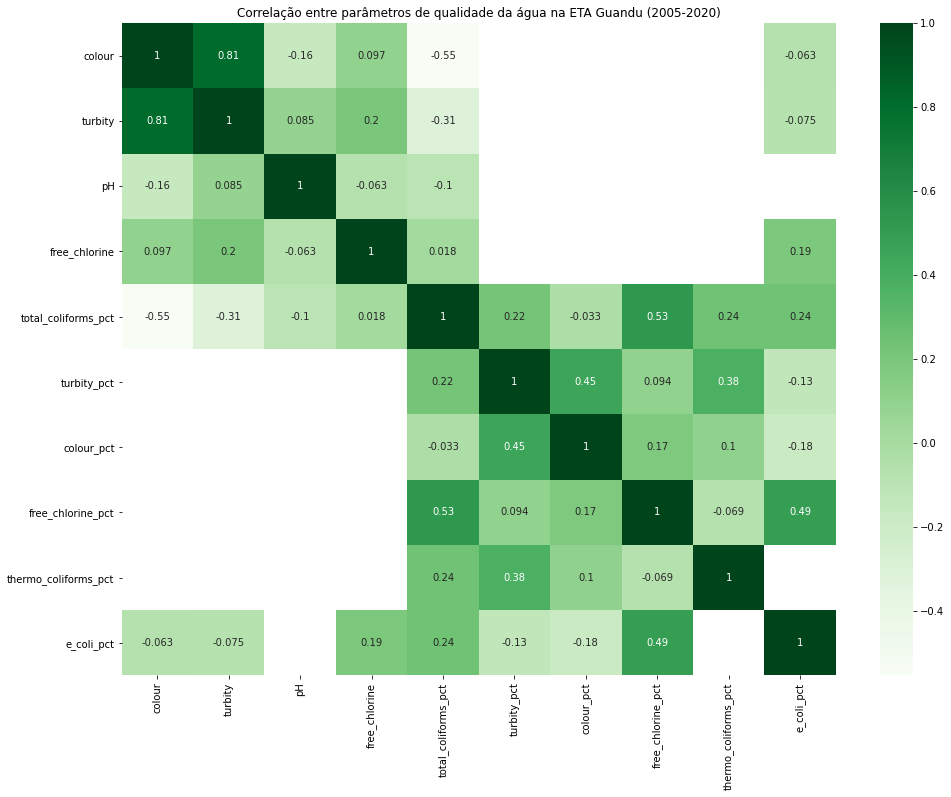

In [163]:
corr = df.drop(columns=['colour_turbity_tests', 'chlorine_bacteriology_tests', 'turbity_cnt', 'colour_cnt',
                       'free_chlorine_cnt', 'total_coliforms_cnt', 'thermo_coliforms_cnt',
                       'chlorine_bacteriology_turbity_tests', 'colour_tests', 'e_coli_cnt',
                       'total_coliforms_rec_pct', 'e_coli_rec_pct', 'total_coliforms_icnt',
                       'thermo_coliforms_icnt'])
print(corr.count())
corr = corr.corr()
plt.figure(figsize=[16,12])
plt.title('Correlação entre parâmetros de qualidade da água na ETA Guandu (2005-2020)')
sn.heatmap(corr, annot=True, cmap='Greens')
plt.show()